In [1]:
import json
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
from utils.molecule_tools import get_molecule
from utils.cs_vqe_tools import greedy_dfs
from matplotlib import pyplot as plt
import numpy as np
from qiskit.aqua.components.optimizers import IMFIL, NELDER_MEAD, POWELL, NFT, SPSA, SLSQP

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
    
model_data.keys()

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'H3+_STO-3G_SINGLET_alt', 'HeH+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET_alt', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET_alt', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'N+_STO-3G_SINGLET', 'OH+_STO-3G_SINGLET', 'CH2_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_SINGLET'])

In [13]:
speciesname = "HF_STO-3G_SINGLET"
molecule    = model_data[speciesname]

ham         = molecule['ham']
uccsd       = molecule['uccsd']
hf_config   = molecule['hf_config']
num_qubits  = molecule['num_qubits']
terms_noncon= molecule['terms_noncon']

print(num_qubits)

8


In [14]:
mol_circ = cs_circ.cs_vqe_circuit(hamiltonian = ham,
                                  terms_noncon= terms_noncon,
                                  num_qubits  = num_qubits,
                                  hf_config   = hf_config)

num_sim_q = mol_circ.chem_acc_num_q
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
mol_circ.plot_cs_vqe_errors()

HF_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


In [15]:
anz_ops = mol_circ.sufficient_anz_terms(uccsd)

Testing operator 1/96
Testing operator 2/96
Testing operator 3/96
Testing operator 4/96
Testing operator 5/96
Testing operator 6/96
Testing operator 7/96
Testing operator 8/96
Testing operator 9/96
Testing operator 10/96
Testing operator 11/96
Testing operator 12/96
Testing operator 13/96
Testing operator 14/96
Testing operator 15/96
Testing operator 16/96
Testing operator 17/96
Testing operator 18/96
Testing operator 19/96
Testing operator 20/96
Testing operator 21/96
Testing operator 22/96
Testing operator 23/96
Testing operator 24/96
Testing operator 25/96
Testing operator 26/96
Testing operator 27/96
Testing operator 28/96
Testing operator 29/96
Testing operator 30/96
Testing operator 31/96
Testing operator 32/96
Testing operator 33/96
Testing operator 34/96
Testing operator 35/96
Testing operator 36/96
Testing operator 37/96
Testing operator 38/96
Testing operator 39/96
Testing operator 40/96
Testing operator 41/96
Testing operator 42/96
Testing operator 43/96
Testing operator 44/

Testing operator 59/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 60/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 61/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 62/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 63/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 64/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 65/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 66/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 71/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 72/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 73/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 74/9

Testing operator 58/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 59/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 60/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 61/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 62/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 63/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 66/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 71/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 72/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 73/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 74/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 79/9

Testing operator 73/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 74/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 79/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 81/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 82/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 87/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 88/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 89/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 90/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 95/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
Testing operator 96/96
*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...
['XXIIXYII', 'YYIIZZY

In [16]:
print(anz_ops)

['XXIIXYII', 'YYIIZZYX', 'XZIIYIII', 'IXIIZZZY', 'YXIIIIXX', 'IXIIZYII', 'IYIIZZZX', 'YXIIYYII', 'YYIIIIYX', 'XYIIYYII']


4-qubit reduced Hamiltonian: {'IIII': -95.96231721459549, 'ZIZI': 0.29388744181718524, 'ZXIZ': 0.07033343124515028, 'IZIZ': -0.29388742559998376, 'IXZZ': 0.004181498913181042, 'ZZZZ': -0.1769860401715367, 'ZIII': 0.6582702190887677, 'IIZI': 1.079643097377037, 'IXIZ': 0.029375344184222944, 'ZZIZ': -0.16691213730025137, 'ZXZZ': 0.045139555422370865, 'IZZZ': -0.16835235269215496, 'ZXII': -0.07033321170035249, 'IZII': -0.658270235305942, 'IXZI': -0.0041814196184795215, 'ZZZI': -0.16691214503763901, 'IIIZ': 1.0796430973770343, 'ZIZZ': 0.168352363100253, 'IXII': -0.02937526266309732, 'ZZII': -0.1866419668285767, 'IIZZ': 0.21458307935557255, 'ZXZI': -0.04513947375455876, 'IZZI': -0.18583792526645784, 'ZIIZ': 0.1858379148583692, 'YYII': 0.04703224565182527, 'XIII': -0.004181447259918904, 'XZIZ': 0.07033336348173252, 'YYZI': -0.04703224565182527, 'XIZI': 0.004181447259918904, 'XZZZ': -0.07033336348173252, 'YYIZ': -0.04703223791443762, 'XIIZ': -0.02937531654278356, 'XZII': 0.04513951660434116, '

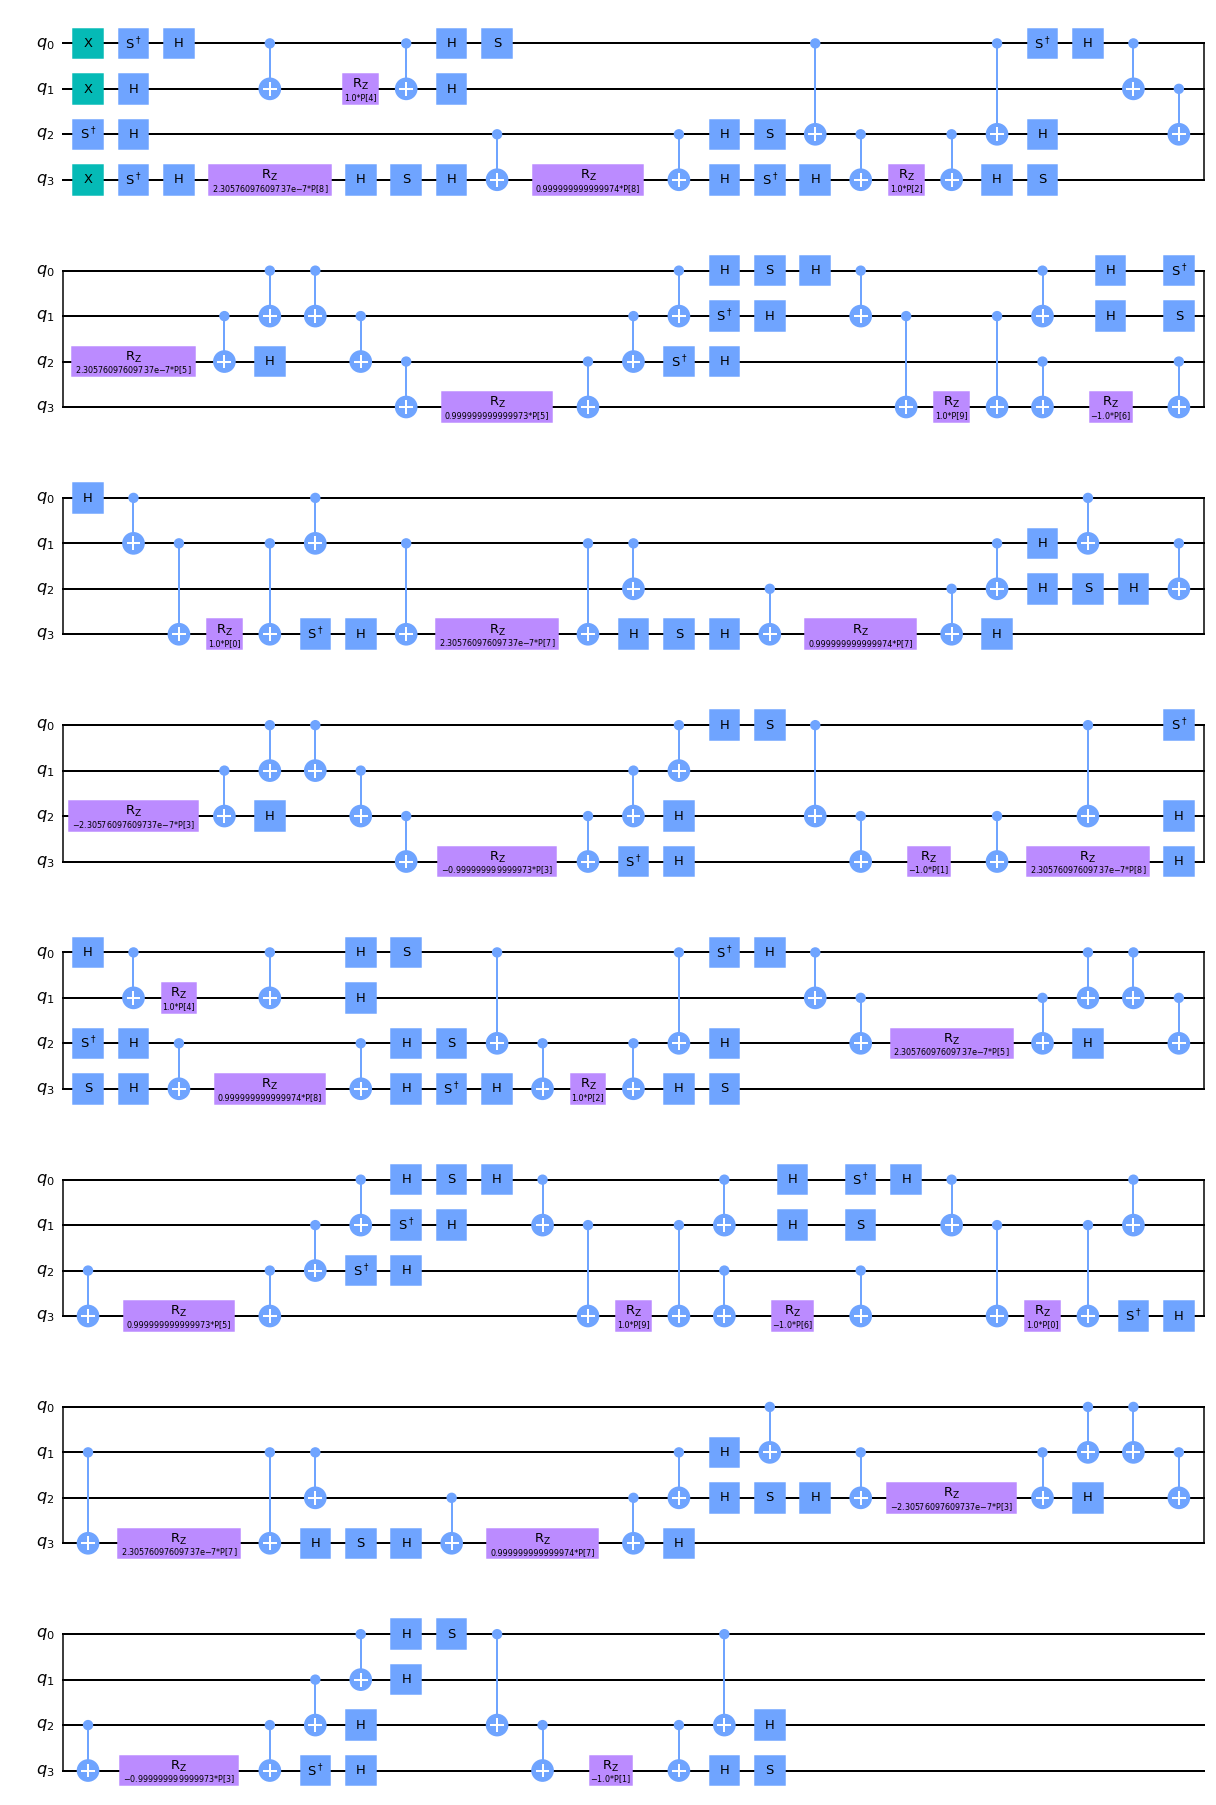

In [19]:
#import random
ham_red = mol_circ.ham_reduced[num_sim_q]
#anz_indices = [random.randint(0, len(uccsd.keys())) for i in range(1)]
#print(anz_indices)
#for B+  anz_ops = ['YIIXX', 'ZYZXX'], new: ['ZXIYX', 'XZZXX', 'YZZXX']
#for Be  anz_ops = ['XZZXX', 'YIIXX', 'IIXYX', 'ZXZXX', 'IZYXX']
#for LiH anz_ops = ['YXIIIIXX', 'IIIIIYZX', 'IIIIYXYY', 'XZIIZYIY', 'IIIIXZYI', 'XXIIIIYX', 'IIIIXXXY', 'IXIIXIIY', 'IYIIXIIY', 'IYIIZZZX', 'IIIIXXYX']
#for HF  anz_ops = ['XYIIXXII', 'XYIIIIXX', 'IYIIZXII', 'YYIIZZYX', 'IYIIZZZX', 'YYIIIIYX', 'XXIIYXII', 'YXIIYYII']
#anz_indices = [49, 97, 71, 72] #for C
#anz = {op:uccsd[op] for op in [list(uccsd.keys())[i] for i in anz_indices]}
#anz = uccsd
#anz_ops = ['ZXIYX', 'XZZXX', 'YZZXX']
anz = {op:uccsd[op] for op in anz_ops}

anz_red = mol_circ.project_anz_terms_alt(anz_terms=anz, num_sim_q = num_sim_q)
ham_red = mol_circ.ham_reduced[num_sim_q]
qc = mol_circ.build_circuit(anz, num_sim_q)
init_params = np.zeros(qc.num_parameters)
bounds = np.array([(p-np.pi, p+np.pi) for p in init_params])
qc.parameter_bounds = bounds

print('%i-qubit reduced Hamiltonian:'%num_sim_q, ham_red, '\n')
print('%i-qubit reduced Ansatz:'%num_sim_q, anz_red, '\n')
print('Corresponding reduced Ansatz circuit:')
qc.draw(output='mpl')

# Performing the simulation *without* noise

*   Performing 4-qubit CS-VQE over qubit positions 3, 2, 1, 0 ...


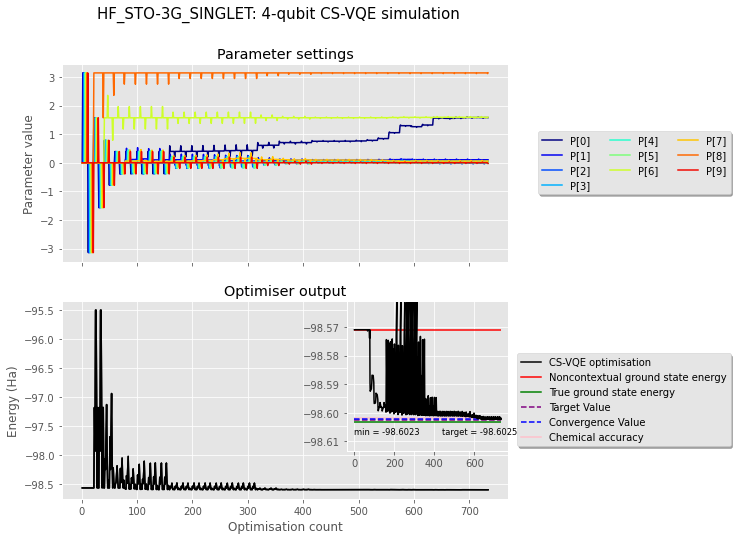

In [20]:
cs_vqe_results = mol_circ.CS_VQE(anz_terms=anz, 
                                 num_sim_q=num_sim_q, 
                                 optimizer=IMFIL(maxiter=10000), 
                                 param_bound=np.pi,
                                 noise=False)

title = '%s: %i-qubit CS-VQE simulation' % (speciesname, num_sim_q)
fig = plot.plot_parameter_settings(cs_vqe_results, title=title)

# Performing the simulation *with* noise

The noise model used below emulates IBM's 5-qubit Vigo device, derived from real-life performance data

In [21]:
import os
from qiskit.algorithms import VQE
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo, FakeTenerife, FakeMelbourne, FakeRueschlikon, FakeTokyo
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter, TensoredMeasFitter

In [22]:
def get_quantum_instance(seed, noise=False, error_mitigation=None):
    algorithm_globals.random_seed = seed
    
    if not noise:
        backend = Aer.get_backend('statevector_simulator')
        qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
    
    else:
        device_backend = FakeRueschlikon()
        backend = Aer.get_backend('aer_simulator')
        noise_model = None
        device = QasmSimulator.from_backend(device_backend)
        coupling_map = device.configuration().coupling_map
        noise_model = NoiseModel.from_backend(device)
        basis_gates = noise_model.basis_gates
        
        qi = QuantumInstance(backend=backend,
                             shots=2**10,
                             seed_simulator=seed, 
                             seed_transpiler=seed,
                             coupling_map=coupling_map, 
                             noise_model=noise_model,
                             measurement_error_mitigation_cls=error_mitigation,
                             measurement_error_mitigation_shots=2**10,
                             cals_matrix_refresh_period=30)
        
    return qi

In [23]:
def vqe_simulation(ansatz, operator, init_params, noise=False, error_mitigation=None):
    
    def store_intermediate_result(eval_count, parameters, mean, std):
        """ Outputs intermediate data during VQE routine
        """
        counts.append(eval_count)
        prmset.append(parameters)
        values.append(mean)
        errors.append(std)
    
    counts=[]
    prmset=[]
    values=[]
    errors=[]
    
    qi = get_quantum_instance(seed=42, noise=noise, error_mitigation=error_mitigation)
    vqe = VQE(ansatz, 
              initial_point=init_params, 
              optimizer=IMFIL(maxiter=1000), 
              callback=store_intermediate_result, 
              quantum_instance=qi) 
    vqe_input_op = qonvert.dict_to_WeightedPauliOperator(operator)
    vqe_run = vqe.compute_minimum_eigenvalue(operator=vqe_input_op)
    
    return {'conval':vqe_run.optimal_value,
            'counts':counts,
            'prmset':prmset,
            'values':values,
            'errors':errors}

Noiseless VQE error: 0.0010026039843182843
Noisy VQE error: 0.001599534467274566
Noisy VQE with error mitigation error: 0.005202812586233563


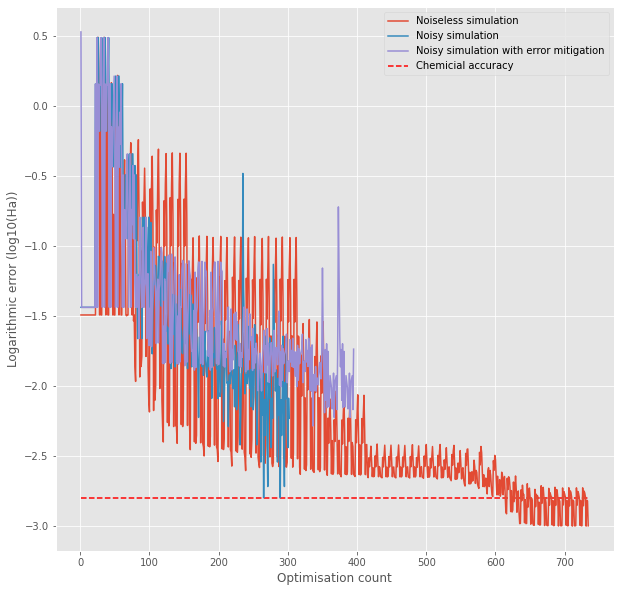

In [24]:
noiseless        = vqe_simulation(ansatz=qc, 
                                  operator=ham_red, 
                                  init_params=init_params, 
                                  noise=False, 
                                  error_mitigation=None)
print('Noiseless VQE error:', noiseless['conval']-mol_circ.true_gs)

noisy            = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=None)
print('Noisy VQE error:', noisy['conval']-mol_circ.true_gs)

noisy_mitigation = vqe_simulation(ansatz=qc, 
                                operator=ham_red, 
                                init_params=init_params, 
                                noise=True, 
                                error_mitigation=CompleteMeasFitter)#TensoredMeasFitter)
print('Noisy VQE with error mitigation error:', noisy_mitigation['conval']-mol_circ.true_gs)

x_lim = max([noiseless['counts'][-1], noisy['counts'][-1], noisy_mitigation['counts'][-1]])

fig, ax = plt.subplots(figsize=(10,10))

#ax.hlines(mol_circ.true_gs, 1, x_lim, color='g', label='True ground state energy', ls='--')
#ax.hlines(mol_circ.true_gs+0.0016, 1, x_lim, color='pink', label='Chemical accuracy', ls='--')
#ax.hlines(mol_circ.gs_noncon_energy, 1, x_lim, color='red', label='Noncon gs energy', ls='--')
ax.hlines(np.log10(0.0016), 1, x_lim, color='red', label='Chemicial accuracy', ls='--')

ax.plot(noiseless['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noiseless['values']], label='Noiseless simulation')
ax.plot(noisy['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy['values']], label='Noisy simulation')
ax.plot(noisy_mitigation['counts'], [np.log10(abs(v-mol_circ.true_gs)) for v in noisy_mitigation['values']], label='Noisy simulation with error mitigation')

ax.set_xlabel('Optimisation count')
ax.set_ylabel('Logarithmic error (log10(Ha))')
ax.legend()

In [33]:
from qiskit import IBMQ

with open('data/token.txt', 'r') as file:
    TOKEN = file.read()

IBMQ.save_account(TOKEN, overwrite=True)

In [34]:
IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-20 21:32:56,588: Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [35]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_manila')

In [36]:
backend.name()

'ibmq_manila'

In [37]:
from qiskit_nature.runtime import VQEProgram

In [38]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

In [39]:
# currently the VQEProgram supports only 'SPSA' and 'QN-SPSA'
optimizer = {
    'name': 'QN-SPSA',  # leverage the Quantum Natural SPSA
    # 'name': 'SPSA',  # set to ordinary SPSA
    'maxiter': 100,
    'resamplings': {1: 100},  # 100 samples of the QFI for the first step, then 1 sample per step
}

runtime_vqe = VQEProgram(ansatz=qc,
                         optimizer=optimizer,
                         initial_point=init_params,
                         provider=provider,
                         backend=backend,
                         shots=1024,
                         measurement_error_mitigation=True,
                         callback=callback)  # use a complete measurement fitter for error mitigation

In [40]:
vqe_input_op = qonvert.dict_to_WeightedPauliOperator(ham_red)
runtime_result = runtime_vqe.compute_minimum_eigenvalue(vqe_input_op)

runtime_job._start_websocket_client:WARNING:2021-10-20 21:58:00,545: An error occurred while streaming results from the server for job c5o7q2qkh8krlc7cst20:
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/runtime/runtime_job.py", line 328, in _start_websocket_client
    self._ws_client.job_results()
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/runtime_ws.py", line 74, in job_results
    self.stream(url=url, retries=max_retries, backoff_factor=backoff_factor)
  File "/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/api/clients/base.py", line 211, in stream
    raise WebsocketError(error_message)
qiskit.providers.ibmq.api.exceptions.WebsocketError: 'Max retries exceeded: Failed to establish a websocket connection. Error: Traceback (most recent call last):\n  File "/home/tim/anaconda3/lib/python3.7/site-packages/websocket/_app.py", line 369, in run_forever\n  

In [ ]:
intermediate_info

In [41]:
runtime_result.eigenvalue

(-96.08464382424118+0j)

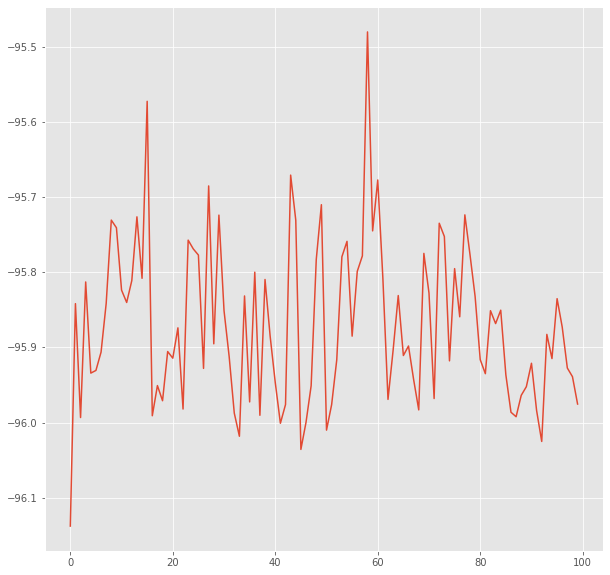

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(intermediate_info['nfev'], intermediate_info['energy'])

In [38]:
#import json 

#data={}
#for k in intermediate_info.keys():
#    data[str(k)] = intermediate_info[k]

#data['parameters'] = [list(t) for t in data['parameters']]
#data['stddev'] = [t.real for t in data['stddev']]

#with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
#    json.dump(data, outfile)

In [43]:
intermediate_info['nfev'] = list(range(len(runtime_result.optimizer_history['loss'])))
intermediate_info['energy'] = runtime_result.optimizer_history['loss']
intermediate_info['parameters'] = runtime_result.optimizer_history['params']

parameters={}
for index, param in enumerate([p.name for p in list(qc.parameters)]):
    parameters[param] = list(zip(*intermediate_info['parameters']))[index]
    
data={'counts':intermediate_info['nfev'],
      'values':intermediate_info['energy'],
      'params':parameters,
      'errors':[t.real for t in intermediate_info['stddev']],
      'true_gs':mol_circ.true_gs,
      'result':runtime_result.optimal_value,
      'target':mol_circ.cs_vqe_energy[num_sim_q],
      'gs_noncon_energy':mol_circ.gs_noncon_energy,
      'optimiser':optimizer['name'],
      'backend':backend.name()}

In [ ]:
import json 

with open("data/IBMQ-runtime/"+speciesname+"_UCCSD_taper_CS-VQE_convergence_projected_ansatz.json", "w") as outfile: 
    json.dump(data, outfile)

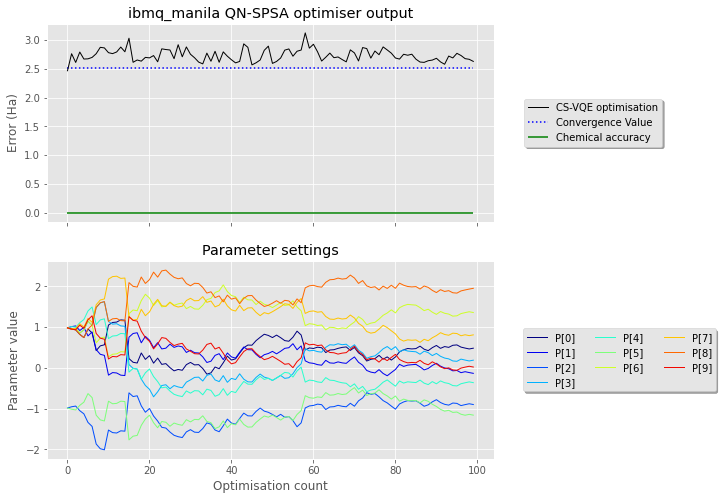

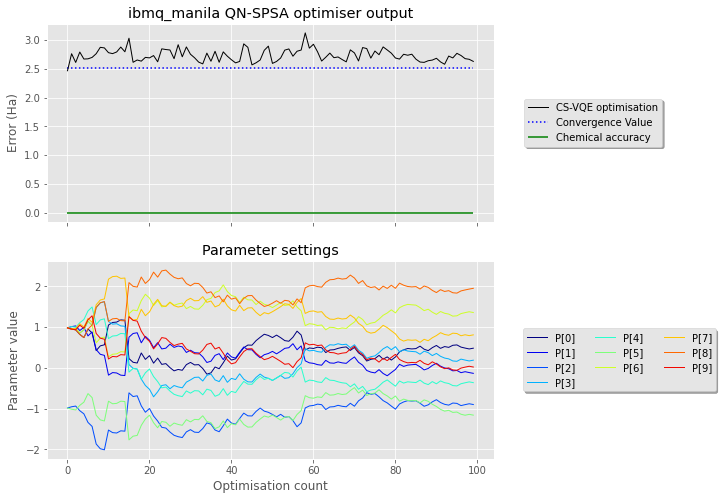

In [45]:
plot.plot_parameter_settings_alt(data)